# Corona Virus Study 1 ; Spread in India -  A Visualization  Study




Referenced Kaggle Kernel:   https://www.kaggle.com/parulpandey/tracking-india-s-coronavirus-spread-wip

##  Import Libraries 

In [15]:
# import the necessary Core  libraries
import numpy as np 
import pandas as pd 
import os

In [13]:
# One time installs 
#!pip install pycountry
#!pip install pywaffle
#!pip install folium

In [12]:
# Import Visualisation libraries
import matplotlib.pyplot as plt
%matplotlib inline
import plotly
import seaborn as sns
sns.set()
import pycountry
import plotly.express as px
from plotly.offline import init_notebook_mode, iplot 
import plotly.graph_objs as go
import plotly.offline as py

from pywaffle import Waffle

py.init_notebook_mode(connected=True)
import folium 
from folium import plugins
plt.style.use("fivethirtyeight")# for pretty graphs

# Increase the default plot size and set the color scheme
plt.rcParams['figure.figsize'] = 8, 5
#plt.rcParams['image.cmap'] = 'viridis'
from plotly.offline import download_plotlyjs,init_notebook_mode,plot,iplot

##  Read Input files 



In [45]:
# Reading the datasets: Source  https://www.mohfw.gov.in/
df= pd.read_excel('Covid cases in India_18_March_2020.xlsx')
df_india = df.copy()

# Coordinates of India States 
India_coord = pd.read_excel('Indian Coordinates.xlsx')

## Pre Process 

In [41]:
# Check data 
df.head(n=2)

,S. No.,Name of State / UT,Total Confirmed cases (Indian National),Total Confirmed cases ( Foreign National ),Cured/Discharged,Death
0,1,Andhra Pradesh,1,0,0,0
1,2,Delhi,9,1,2,1


In [42]:
# Get column names 
df.columns

Index(['S. No.', 'Name of State / UT',
       'Total Confirmed cases (Indian National)',
       'Total Confirmed cases ( Foreign National )', 'Cured/Discharged',
       'Death'],
      dtype='object')

In [46]:
# Rename to shorter column names 

df.rename(columns= {'Name of State / UT':'State_UT', 'Total Confirmed cases (Indian National)':'Tot_Conf_IN',
       'Total Confirmed cases ( Foreign National )':'Tot_Conf_FRGN', 'Cured/Discharged':'Recovered',
       'Death':'Deaths'},inplace= True)

# Check
df.head()

In [49]:
# Drop irrelevant columns
df.drop(['S. No.'],axis=1,inplace=True)

# Create computed Col <Total cases> 
df['Total_cases'] = df['Tot_Conf_IN'] + df['Tot_Conf_FRGN']

# Create computed col <Active Cases>
df['Active_cases'] = df['Total_cases'] - (df['Recovered'] + df['Deaths'])

# Check 
df.head()

,State_UT,Tot_Conf_IN,Tot_Conf_FRGN,Recovered,Deaths,Total_cases,Active_cases
0,Andhra Pradesh,1,0,0,0,1,1
1,Delhi,9,1,2,1,10,7
2,Haryana,2,14,0,0,16,16
3,Karnataka,11,0,0,1,11,10
4,Kerala,25,2,3,0,27,24


## 1.0 Overall Picture 

In [99]:
# Get totals 
Total_cases  = df['Total_cases'].sum()
Total_active = df['Active_cases'].sum()
Total_deaths = df['Deaths'].sum()
Total_cured  = df['Recovered'].sum()


# Create Dict 
dict1 = {'Total cases':Total_cases, 'Active cases':Total_active,'Total deaths':Total_deaths,'Total cured':Total_cured}

# Convert to DF 
df_totals= pd.DataFrame.from_dict(dict1,orient='index',columns=['Count'])
df_totals = df_totals.reset_index()

df_totals.rename(columns= {'index':'Case Classification'},inplace= True)

In [101]:

#
fig = px.bar(df_totals, x='Case Classification', y='Count',
             hover_data=['Count'], color='Count',
             labels={'Count':'Count'},text = 'Count',height=400)
fig.show()

## 1.1 Distribution of Cases in India

In [61]:

def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: pink' if v else '' for v in is_max]


df.style.apply(highlight_max,subset=['Recovered', 'Deaths','Total_cases','Active_cases'])

,State_UT,Tot_Conf_IN,Tot_Conf_FRGN,Recovered,Deaths,Total_cases,Active_cases
0,Andhra Pradesh,1,0,0,0,1,1
1,Delhi,9,1,2,1,10,7
2,Haryana,2,14,0,0,16,16
3,Karnataka,11,0,0,1,11,10
4,Kerala,25,2,3,0,27,24
5,Maharashtra,38,3,0,1,41,40
6,Odisha,1,0,0,0,1,1
7,Punjab,1,0,0,0,1,1
8,Rajasthan,2,2,3,0,4,1
9,Tamil Nadu,1,0,0,0,1,1


## 1.2 State/Union Territories wise number of Covid-19 cases

In [85]:

# Horizontal bar graph with color map based 
fig = px.bar(df.sort_values('Active_cases', ascending=True), 
             x="Active_cases", y="State_UT", title='Total Active Cases', text='Active_cases', orientation='h', 
             width=700, height=700, range_x = [0, max(df['Active_cases'])],color = 'Active_cases',color_continuous_scale=px.colors.sequential.thermal)


fig.show()

## 1.3 National vs Foreign cases

In [105]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots


# create a subplot instance with 1 row and 2 cols 
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=("National Cases","Foreign Cases"))

# Sort and hold in temp DF :  Total Indian Nationals  confirmed cases 
temp1 = df.sort_values('Tot_Conf_IN', ascending=False)
# Sort and hold in temp DF :  Total Foreign Nationals  confirmed cases 
temp2 = df.sort_values('Tot_Conf_FRGN', ascending=False)


# Rename to explanatory column names 
temp1.rename(columns= {'Tot_Conf_IN':'Total Confirmed cases (Indian National)'},inplace= True)
temp2.rename(columns= {'Tot_Conf_FRGN':'Total Confirmed cases ( Foreign National )'},inplace= True)

# Add Indian Nationals Plot at Pos 1,1 
fig.add_trace(go.Bar( y=temp1['Total Confirmed cases (Indian National)'], x=temp1["State_UT"],  
                     marker=dict(color=temp1['Total Confirmed cases (Indian National)'], coloraxis="coloraxis")),
              1, 1)
# Add Foreign National Plot at Pos 1,2                      
fig.add_trace(go.Bar( y=temp2['Total Confirmed cases ( Foreign National )'], x=temp2["State_UT"],  
                     marker=dict(color=temp2['Total Confirmed cases ( Foreign National )'], coloraxis="coloraxis")),
              1, 2)                     
                     
# Plot Titles setting
fig.update_layout(coloraxis=dict(colorscale='rdbu'), showlegend=False,title_text="National vs Foreign Cases",plot_bgcolor='rgb(250, 242, 242)')
fig.show()






## 1.4 Visualising the spread geographically

In [ ]:
# create map and display it

df_full = pd.merge(India_coord,df,on='Name of State / UT')
map = folium.Map(location=[20, 80], zoom_start=3.5,tiles='Stamen Toner')

for lat, lon, value, name in zip(df_full['Latitude'], df_full['Longitude'], df_full['Active cases'], df_full['Name of State / UT']):
    folium.CircleMarker([lat, lon],
                        radius=value*0.7,
                        popup = ('<strong>State</strong>: ' + str(name).capitalize() + '<br>'
                                '<strong>Confirmed Cases</strong>: ' + str(value) + '<br>'),
                        color='red',
                        
                        fill_color='red',
                        fill_opacity=0.3 ).add_to(map)
map

## 1.5 Confirmed vs Recovered figures

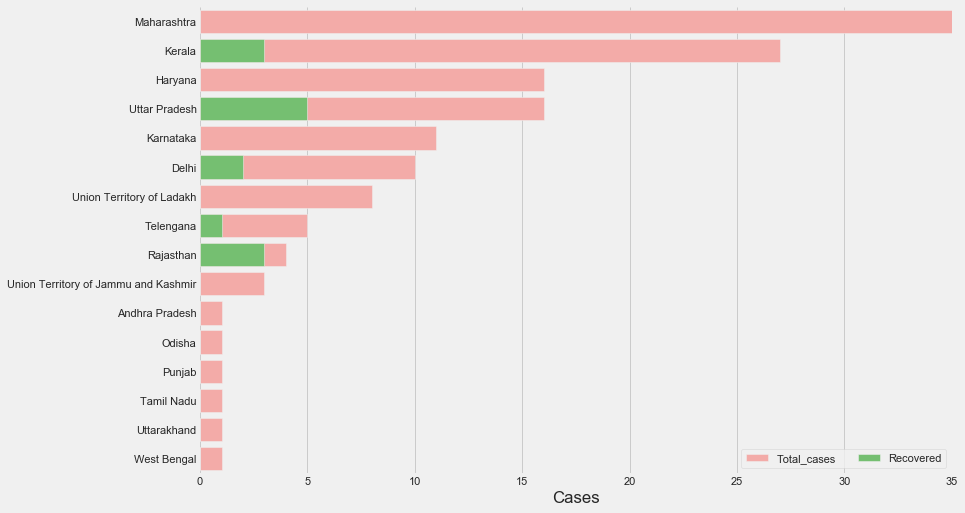

In [106]:
# Plotting with subplots and Seaborne 

Total_cases  = df['Total_cases'].sum()
Total_active = df['Active_cases'].sum()
Total_deaths = df['Deaths'].sum()
Total_cured  = df['Recovered'].sum()

# define subplot instance 
f, ax = plt.subplots(figsize=(12, 8))

# Subset only relevant data 
data = df[['State_UT','Total_cases','Recovered','Deaths']]

# Sort descending on Total Cases 
data.sort_values('Total_cases',ascending=False,inplace=True)

# Set Seaborne parameters
sns.set_color_codes("pastel")


sns.barplot(x="Total_cases", y="State_UT", data=data,
            label="Total_cases", color="r")

sns.set_color_codes("muted")

sns.barplot(x="Recovered", y="State_UT", data=data,
            label="Recovered", color="g")


# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(0, 35), ylabel="",
       xlabel="Cases")
sns.despine(left=True, bottom=True)